# 1. Problem Statement

* Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate days  in  at  least  one  seven-day  period,  identify  which  factors  predict  future  user adoption.

Here's my approach:

* 1. Load the data and see what the meta statistics tell me about the data.
* 2. Parse the engagement data to find who has logged in on 3 separate days within any 7-day period.
    * Add a column to the users table, adopted, with a 1 for all users who meet this criterion.
* 3. Now I have my labelled data, with adopted as the boolean target.
* 4. Will do a classification problem with the other columns as potential features to predict the adoption target.

## 1.1 Data Definitions

1]  A  user  table  ( "takehome_users" )  with  data  on  12,000  users  who  signed  up  for  the
product  in  the  last  two  years.   This  table  includes:
* name:  the  user's  name
* object_id:   the  user's  id
* email:  email  address
* creation_source:   how  their  account  was  created.  This  takes  on  one
of  5  values:
    * PERSONAL_PROJECTS:  invited  to  join  another  user's
personal  workspace
    * GUEST_INVITE:  invited  to  an  organization  as  a  guest
(limited  permissions)
    * ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
    * SIGNUP:  signed  up  via  the  website
    * SIGNUP_GOOGLE_AUTH:  signed  up  using  Google
Authentication  (using  a  Google  email  account  for  their  login
id)
* creation_time:  when  they  created  their  account
* last_session_creation_time:   unix  timestamp  of  last  login
* opted_in_to_mailing_list:  whether  they  have  opted  into  receiving
marketing  emails
* enabled_for_marketing_drip:  whether  they  are  on  the  regular
marketing  email  drip
* org_id:   the  organization  (group  of  users)  they  belong  to
* invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).

2]  A  usage  summary  table  ( "takehome_user_engagement" )  that  has  a  row  for  each  day
that  a  user  logged  into  the  product.

# 2. Load Python packages and data

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## 2.1 Users file

In [2]:
## takehome_users.csv was not UTF-8 encoded.  
## Had to open in Google Sheets and download as CSV to encode it to make it usable.
users = pd.read_csv('takehome_users.csv')

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 3:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 3:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 8:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
users.info()
users.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [5]:
8823 / 12000

0.73525

## 2.2 Users file initial remarks

The takehome_users file was not UTF-8 encoded.  Had to use Google Sheets to encode it and make it usable to Python and Jupyter.

12,000 users in this data table.  All columns have full 12,000 entries except:
* Only 73.5% have a last session creation time.  Apparently only 73.5% have ever logged in.  These cannot be adopters.
* Just over 50% were invited by another user.

User # 12000 must have been invited by # 11999.
There are 416 organizations using our product.
Only 15% of users are enabled for marketing email drip.
25% have opted into the mailing list.

## 2.3 A bit of Data Wrangling

The last_session_creation_time is a Unix timestamp. And creation_time has a datetime format, but it is a string.  Let's convert them both to datetime.

In [29]:
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit='s')
users.creation_time = pd.to_datetime(users.creation_time)
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  int32         
 10  adopted                     12000 non-null  int32         
dtypes: datetime64[ns](2), int32(2), int64(4), object(3)
me

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,0


## 2.4 Engagement file

In [7]:
engagement = pd.read_csv("takehome_user_engagement.csv")
engagement

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [8]:
engagement.info()
engagement.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


## 2.5 Engagement file initial remarks

207917 rows.  No missing data.  That's an average of 16 3/4 visits per user.  Since 26.5% of the users have never visited, it's closer to 20 visits per active user.

The visited column appears to give us no information.  All rows have visited=1.  If  you've logged in, you've visited, so by definition all of the users in this list have visited.

# 3. Parse Engagement data to find which users have visited 3 days out of any stretch of 7 days.

## 3.1 Create a date-only column out of the timestamp column.

In [9]:
engagement['date'] = pd.to_datetime(engagement.time_stamp).dt.date

In [10]:
print(type(engagement.date[0]))
engagement.head()

<class 'datetime.date'>


,time_stamp,user_id,visited,date
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


## 3.2 Create an adopted column in user based on adoption criterion of engagement.

In [11]:
grp = engagement.groupby(by='user_id')
grouped_lists = grp['date'].apply(list)
gl = grouped_lists[grouped_lists.apply(len) > 2]
gl

user_id
2        [2013-11-15, 2013-11-29, 2013-12-09, 2013-12-2...
10       [2013-01-16, 2013-01-22, 2013-01-30, 2013-02-0...
20       [2014-03-11, 2014-03-12, 2014-03-13, 2014-05-0...
33       [2014-03-11, 2014-03-17, 2014-03-22, 2014-03-2...
42       [2012-11-13, 2012-12-16, 2012-12-18, 2012-12-2...
                               ...                        
11975    [2013-03-29, 2013-04-04, 2013-04-10, 2013-04-1...
11980    [2014-02-02, 2014-03-01, 2014-03-08, 2014-03-1...
11981     [2013-03-06, 2013-03-21, 2013-03-25, 2013-04-02]
11988    [2014-03-17, 2014-03-18, 2014-03-19, 2014-03-2...
11991    [2014-04-20, 2014-04-25, 2014-04-28, 2014-05-1...
Name: date, Length: 2248, dtype: object

In [12]:
def find_adopted(dates):
    if len(dates) < 3:   ## Should be already removed by pandas code above
        return 0
    for d in range(len(dates)-2):    
        if dates[d+2] - dates[d] < datetime.timedelta(8):
            return 1
    return 0
    
adopted = gl.apply(find_adopted)

In [13]:
adopted.describe()

count    2248.000000
mean        0.736655
std         0.440546
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: date, dtype: float64

In [14]:
users['adopted'] = adopted
users.adopted = users.adopted.fillna(0).astype(int)

In [15]:
print(users[['adopted']].sum())
users[['adopted']].count()

adopted    1656
dtype: int64


adopted    12000
dtype: int64

In [16]:
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,0


# 4. Prepare data 

...  users data to classify/predict the target column, adopted.


## 4.1 Data Wrangling

In steps 2.1 through 2.5 we found the data is solid, made a couple of insights, and converted the Unix timestamp to datetime.

The object_id is really the user_id and it is referenced as a foreign key in invited_by_user_id, when a user was invited by another user.  invited_by_user_id is null when no one invited this user.  I'll change the name to user_id to make more sense.

object_id is an integer, but invited... has null values, so it has to be a float.  Let's convert null invited.. values to 0, and make it an int.  I'll verify invited_by_user_id is a whole number and if so, make it an int.


In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted                     12000 non-null  int32         
dtypes: datetime64[ns](2), float64(1), int32(1), int64(4), 

In [18]:
np.array_equal(users.invited_by_user_id[users.invited_by_user_id.notnull()], 
               users.invited_by_user_id[users.invited_by_user_id.notnull()].astype(int))

True

In [19]:
users.rename(columns={'object_id':'user_id'}, inplace=True)
users.invited_by_user_id.fillna(0, inplace=True)
users.invited_by_user_id = users.invited_by_user_id.astype(int)
users.invited_by_user_id.isnull().sum()

0

In [20]:
users.describe()

,user_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,0.249500,0.149333,141.884583,3188.691333,0.138000
std,3464.24595,0.432742,0.356432,124.056723,3869.027693,0.344914
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3000.75000,0.000000,0.000000,29.000000,0.000000,0.000000
50%,6000.50000,0.000000,0.000000,108.000000,875.000000,0.000000
75%,9000.25000,0.000000,0.000000,238.250000,6317.000000,0.000000
max,12000.00000,1.000000,1.000000,416.000000,11999.000000,1.000000


## 4.2 Exploratory Data Analysis

### 4.2.1 Looking at the distributions of the variables...

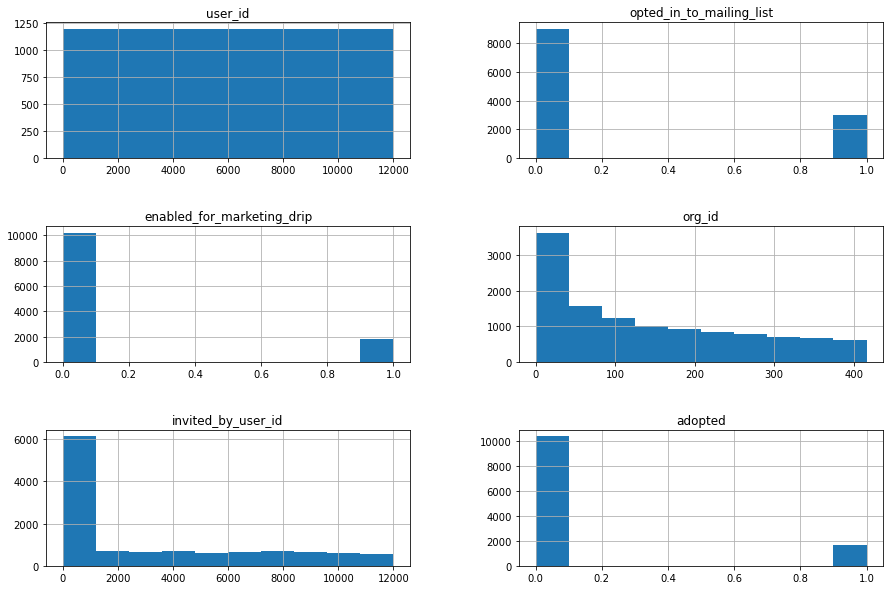

In [21]:
users.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

It looks like the adopted users are pretty much the same size as the users who have enabled marketing emails.  Looking at the numbers, just under 3000 (1/4 of the total) users opted into the mailing list.  About 1800 users (15% of the total) enabled the marketing drip email.  Finally, we labeled 13.8% of users, 1656 of them, as "adopted".

Of course, the user_id is uniformly distributed.  

invited_by_user_id has a lot of 0s (not invited), and is close to uniform other than that.

org_id is the only interesting numeric distribution.  There are a lot of 0s.  Other than that it looks like a geometric distribution, if we consider org_ids as a discrete set of about 400 organizations.

Let's look at last_session_created_time.

In [39]:
#pd.to_datetime(users.last_session_creation_time)
users[users.last_session_creation_time.isnull()].count()

user_id                       3177
creation_time                 3177
name                          3177
email                         3177
creation_source               3177
last_session_creation_time       0
opted_in_to_mailing_list      3177
enabled_for_marketing_drip    3177
org_id                        3177
invited_by_user_id            3177
adopted                       3177
dtype: int64

<AxesSubplot:>

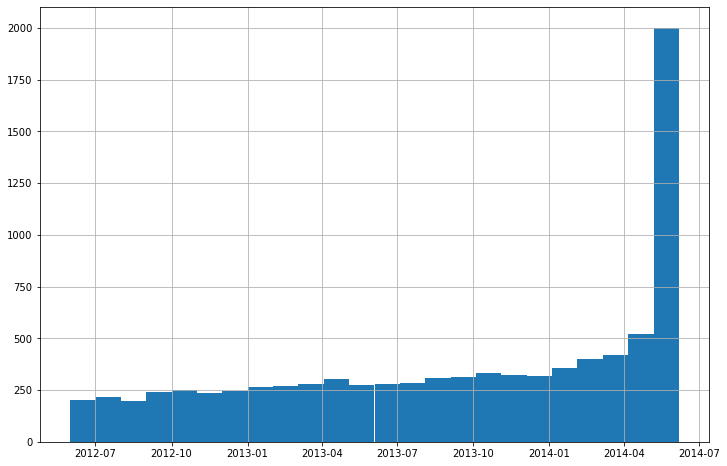

In [37]:
users.last_session_creation_time.hist(figsize=(12, 8), bins=24)

So 3177 users have never logged in.

This is a last login date, which is a reverse-cumulative variable, if you will.  Anyone who logged in during the most recent month will not show up in prior month.

About 2000 have logged on in the last month (June 2014).

Just over 500 logged on in the previous month (May 2014), but not this month. and the numbers of last logins dwindle slowly as we look back month by month.  Some 200 users logged on in the first month (June 2012), but have not done so since.

<AxesSubplot:>

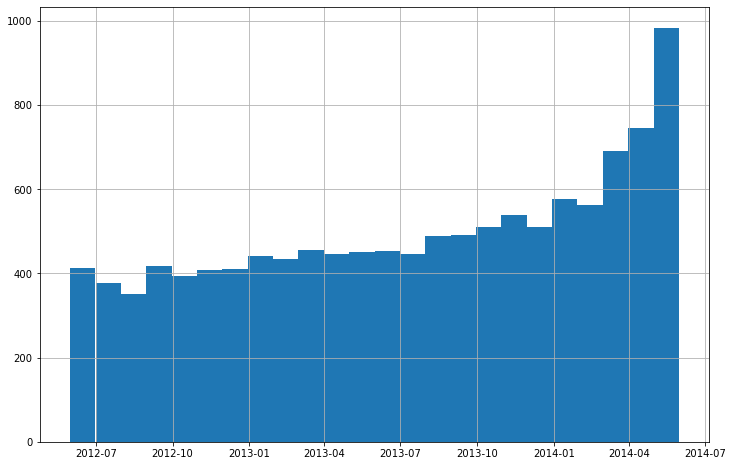

In [40]:
users.creation_time.hist(figsize=(12, 8), bins=24)

Creation time is a single event for each user, very different from last_session_creation_time.  The growing histogram shows us that the number of users added has generally gone up each month, with some lulls.  The biggest month for new users was this last month (June 2014), when over 950 users were creted.

Creation source is a categorical variable.  We see below there are 5 categories.  

About 4300 users were invited to an organization (as a full member), about 2150 were invited to an organization as a guest, about 2100 were invited to join another user's personal workspace, another 2100 signed up via the website, and about 1400 signed up using Google Authentication (using a Google email account for their login id).

<AxesSubplot:>

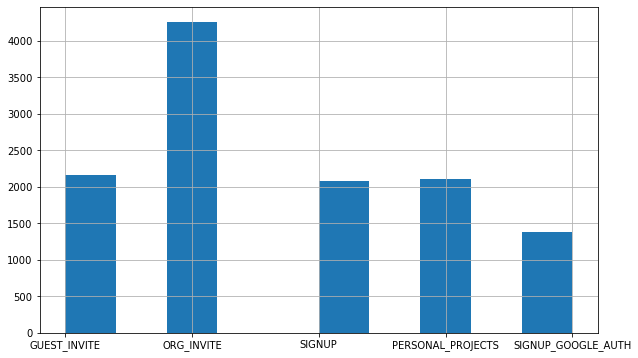

In [78]:
users.creation_source.hist(figsize=(10, 6))

### 4.2.2 Looking at the correlations...

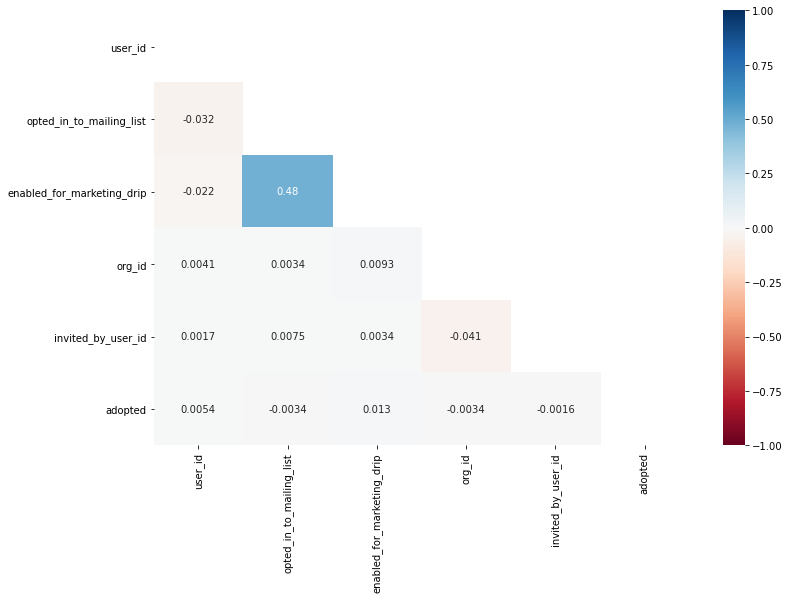

In [57]:
plt.subplots(figsize=(12,8))
mask = np.triu(np.ones_like(users.corr()))
sns.heatmap(users.corr(method='pearson'), mask=mask, vmin=-1, vmax=1, cmap='RdBu', center=0.0, annot=True); 

I tried Spearman rank and Kendall Tau correlations also.  They showed some differences, but the relative strengths were the same and the largest correlation of 0.48 for enabled_for_mareting_drip and opted_in_to_mailing_list was exactly the same for all three, so I kept the standard Pearson correlation coefficient.

I am surprised that the opted in and enabled tags are not correlated to adopted, and that their correlation to each other is only 0.48, given that the numbers of each were very similar.   That's why you should not make assumptions without digging into the data.  Apparently many adopters do not opt in for the email and marketing drip.

C:\Users\bradd\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


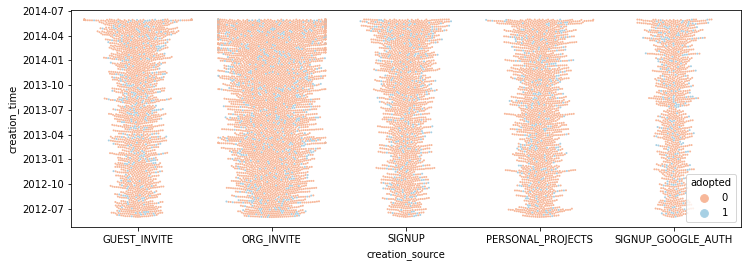

In [107]:
plt.subplots(figsize=(12,4))
ax = sns.swarmplot(x="creation_source", y="creation_time", hue='adopted', size=2,
                    data=users, palette="RdBu")

This swarm plot tells us that the biggest source of users is ORG_INVITE and the smallest number signed up using their Gmail id.  The creation_source histogram already told us that.

It also tells us that the number of users is growing from each source.  That's a good business sign.

One can see blue dots (adoptees) in there, but they are spread thinly throughout.  No signs of correlation to adopted, just like the correlation matrix said.

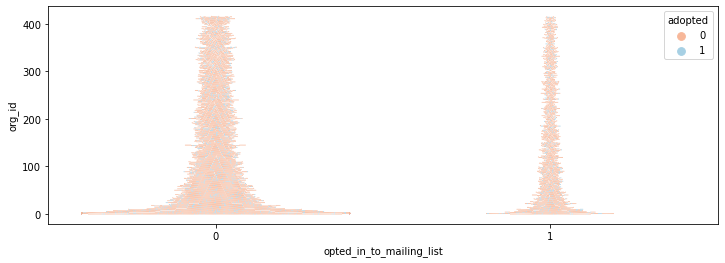

In [111]:
plt.subplots(figsize=(12,4))
ax = sns.swarmplot(y="org_id", x="opted_in_to_mailing_list", hue='adopted', size=1,
                    data=users, palette="RdBu")

This swarm plot tells us that no organization (org_id = 0) has more users than any single organization, and that a lot more users have not opted into the mailing list than have.  Again, there's no concentration of users who have adopted the service in either variable.

## 4.2.3 Analysis

In summary, we don't have any tight cross-correlations among the potential features, nor between the features and the target.  We'll use all the potential features to try to classify users as adopters.

# 4.3 Feature Engineering



In [114]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  int32         
 10  adopted                     12000 non-null  int32         
dtypes: datetime64[ns](2), int32(2), int64(4), object(3)
me

The target is the adopted binary label we created from the engagements table.

In [117]:
y = users.adopted
y.describe()

count    12000.000000
mean         0.138000
std          0.344914
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: adopted, dtype: float64

We won't try to use user_id, name, email name or email domain as features.  We'll move user_id into the index.

In [126]:
features = users.drop(columns=['adopted','name','email'])
features.set_index('user_id', inplace=True)
features.info()
features.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   creation_source             12000 non-null  object        
 2   last_session_creation_time  8823 non-null   datetime64[ns]
 3   opted_in_to_mailing_list    12000 non-null  int64         
 4   enabled_for_marketing_drip  12000 non-null  int64         
 5   org_id                      12000 non-null  int64         
 6   invited_by_user_id          12000 non-null  int32         
dtypes: datetime64[ns](2), int32(1), int64(3), object(1)
memory usage: 703.1+ KB


,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
user_id,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316
3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525
4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151
5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240


Creation_time and last_session_creation_time are datetimes.

Creation_source is a categorical, will one-hot encode the values and drop one.

Opted_ and enabled_ are booleans.

org_id has many values.  We'll call it a numeric variable and scale it for the scaled set.  Some organizations may have more adopters than others, although it did not show up in the correlation heatmap or the swarmplot.

We'll add a boolean, **in_org**, which will be True if org_id is non-zero, False if zero.

invited_by_user is an interesting feature with the potential to show one mode by which our product adoption grows.  Let's make two features out of this.  1. A boolean, **was_invited**, to show if this user was invited by another.  2. An integer, **num_invited**, to count how many other users this user invited.

We will run another correlation heatmap on our features.

In [127]:
## Use one-hot encoding, dropping one category's column to avoid collinearity
features = pd.get_dummies(features, prefix='cs', columns=['creation_source'], drop_first=True)
features.info()
features.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   last_session_creation_time  8823 non-null   datetime64[ns]
 2   opted_in_to_mailing_list    12000 non-null  int64         
 3   enabled_for_marketing_drip  12000 non-null  int64         
 4   org_id                      12000 non-null  int64         
 5   invited_by_user_id          12000 non-null  int32         
 6   cs_ORG_INVITE               12000 non-null  uint8         
 7   cs_PERSONAL_PROJECTS        12000 non-null  uint8         
 8   cs_SIGNUP                   12000 non-null  uint8         
 9   cs_SIGNUP_GOOGLE_AUTH       12000 non-null  uint8         
dtypes: datetime64[ns](2), int32(1), int64(3), uint8(4)
memory usage: 656.2 KB


,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,cs_ORG_INVITE,cs_PERSONAL_PROJECTS,cs_SIGNUP,cs_SIGNUP_GOOGLE_AUTH
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.249500,0.149333,141.884583,3188.691333,0.354500,0.175917,0.173917,0.115417
std,0.432742,0.356432,124.056723,3869.027693,0.478381,0.380765,0.379054,0.319537
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,108.000000,875.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,238.250000,6317.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,416.000000,11999.000000,1.000000,1.000000,1.000000,1.000000


In [133]:
features['in_org'] = (features.org_id > 0) * 1
features['was_invited'] = (features.invited_by_user_id > 0) * 1

In [151]:
invitation_counts = features.groupby(by='invited_by_user_id').count().creation_time
invitation_counts

invited_by_user_id
0        5583
3           1
7           5
10          1
21          1
         ... 
11981       1
11986       1
11994       7
11997       1
11999       7
Name: creation_time, Length: 2565, dtype: int64

In [156]:
features['num_invited'] = invitation_counts
features.num_invited.fillna(0, inplace=True)
features.num_invited = features.num_invited.astype(int)

In [160]:
features.loc[[1,2,3,7,10,21,11981,11986,11994,11997,11999,12000]]

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,cs_ORG_INVITE,cs_PERSONAL_PROJECTS,cs_SIGNUP,cs_SIGNUP_GOOGLE_AUTH,in_org,was_invited,num_invited
user_id,,,,,,,,,,,,,
1,2014-04-22 03:53:30,2014-04-22 03:53:30,1,0,11,10803,0,0,0,0,1,1,0
2,2013-11-15 03:45:04,2014-03-31 03:45:04,0,0,1,316,1,0,0,0,1,1,0
3,2013-03-19 23:14:52,2013-03-19 23:14:52,0,0,94,1525,1,0,0,0,1,1,1
7,2012-12-16 13:24:32,2012-12-20 13:24:32,0,1,37,0,0,0,1,0,1,0,5
10,2013-01-16 22:08:03,2014-06-03 22:08:03,1,1,318,4143,1,0,0,0,1,1,1
21,2013-01-22 12:27:42,2013-01-22 12:27:42,0,0,54,0,0,1,0,0,1,0,1
11981,2013-03-05 01:53:48,2013-04-02 01:53:48,0,0,110,5775,0,0,0,0,1,1,1
11986,2012-06-24 01:02:14,2012-07-01 01:02:14,0,0,111,0,0,0,0,1,1,0,1
11994,2012-06-05 04:46:16,NaT,0,0,84,5450,0,0,0,0,1,1,7


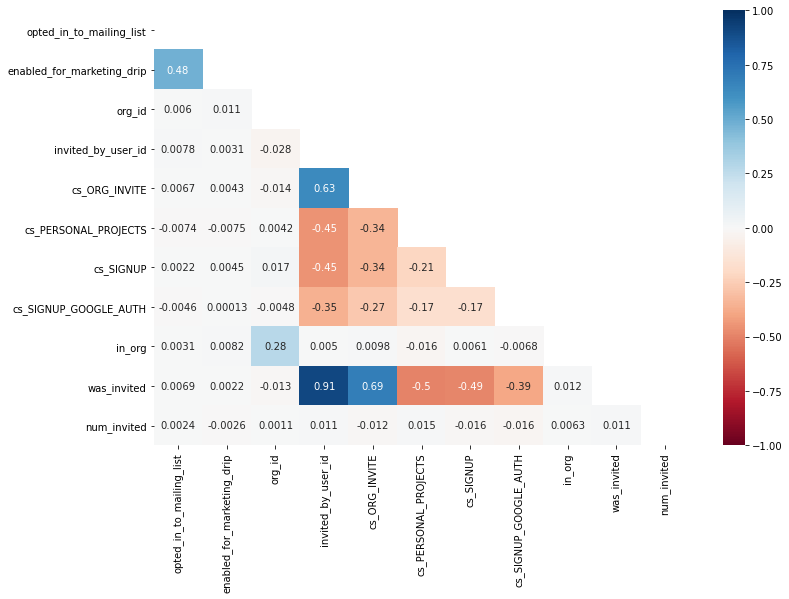

In [164]:
plt.subplots(figsize=(12,8))
mask = np.triu(np.ones_like(features.corr()))
sns.heatmap(features.corr(method='spearman'), mask=mask, vmin=-1, vmax=1, cmap='RdBu', center=0.0, annot=True); 

The was_invited feature correlates 0.91 with invited_by_user_id, according to the Spearman correlation.  Kendall Tau showed 0.8 and Pearson showed 0.77.  Going with the worst-case.  Since I used invited_by.. to create was_invited, this is not surprising.  Should probably use one or the other.  Let's look at the Spearman correlation of each to other factors.

* Correlations * ORG_INV  PERSONAL  SIGNUP  GOOGLE  
* was_invited        * 0.69     -0.5      -0.49   -0.39
* invited_by_user_id * 0.63     -0.45     -0.45   -0.35

was_invited has the higher correlations, probably because it is a boolean, doesn't have all the user_id values that invited_by_user_id has to clutter up the signal.

Let's run Variance Inflation Factor to verify which one to drop.

In [193]:
feat = features.drop(columns=['creation_time','last_session_creation_time'])
X = add_constant(feat)
print(X.columns)
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

Index(['const', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'org_id', 'invited_by_user_id', 'cs_ORG_INVITE', 'cs_PERSONAL_PROJECTS',
       'cs_SIGNUP', 'cs_SIGNUP_GOOGLE_AUTH', 'in_org', 'was_invited',
       'num_invited'],
      dtype='object')


const                         0.000000
opted_in_to_mailing_list      1.305287
enabled_for_marketing_drip    1.305354
org_id                        1.039406
invited_by_user_id            2.449969
cs_ORG_INVITE                 1.916368
cs_PERSONAL_PROJECTS               inf
cs_SIGNUP                          inf
cs_SIGNUP_GOOGLE_AUTH              inf
in_org                        1.037644
was_invited                        inf
num_invited                   1.001371
dtype: float64

In [194]:
X = feat.drop(columns='was_invited')
X = add_constant(X)
print(X.columns)
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

Index(['const', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'org_id', 'invited_by_user_id', 'cs_ORG_INVITE', 'cs_PERSONAL_PROJECTS',
       'cs_SIGNUP', 'cs_SIGNUP_GOOGLE_AUTH', 'in_org', 'num_invited'],
      dtype='object')


const                         48.878211
opted_in_to_mailing_list       1.305287
enabled_for_marketing_drip     1.305354
org_id                         1.039406
invited_by_user_id             2.449969
cs_ORG_INVITE                  1.916368
cs_PERSONAL_PROJECTS           2.457731
cs_SIGNUP                      2.444933
cs_SIGNUP_GOOGLE_AUTH          2.035534
in_org                         1.037644
num_invited                    1.001371
dtype: float64

In [195]:
X.describe()

,const,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,cs_ORG_INVITE,cs_PERSONAL_PROJECTS,cs_SIGNUP,cs_SIGNUP_GOOGLE_AUTH,in_org,num_invited
count,12000.0,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,1.0,0.249500,0.149333,141.884583,3188.691333,0.354500,0.175917,0.173917,0.115417,0.973417,0.534750
std,0.0,0.432742,0.356432,124.056723,3869.027693,0.478381,0.380765,0.379054,0.319537,0.160869,1.350473
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.0,0.000000,0.000000,108.000000,875.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.0,0.000000,0.000000,238.250000,6317.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.0,1.000000,1.000000,416.000000,11999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000


In [183]:
X.describe()

,const,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,cs_ORG_INVITE,cs_PERSONAL_PROJECTS,cs_SIGNUP,cs_SIGNUP_GOOGLE_AUTH,in_org,was_invited,num_invited
count,12000.0,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,1.0,0.249500,0.149333,141.884583,3188.691333,0.354500,0.175917,0.173917,0.115417,0.973417,0.534750,0.534750
std,0.0,0.432742,0.356432,124.056723,3869.027693,0.478381,0.380765,0.379054,0.319537,0.160869,0.498812,1.350473
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.0,0.000000,0.000000,108.000000,875.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,1.0,0.000000,0.000000,238.250000,6317.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.0,1.000000,1.000000,416.000000,11999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000


In [196]:
X = feat.drop(columns='invited_by_user_id')
X = add_constant(X)
print(X.columns)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], 
           index=X.columns)

Index(['const', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'org_id', 'cs_ORG_INVITE', 'cs_PERSONAL_PROJECTS', 'cs_SIGNUP',
       'cs_SIGNUP_GOOGLE_AUTH', 'in_org', 'was_invited', 'num_invited'],
      dtype='object')


C:\Users\bradd\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\bradd\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


const                         0.000000
opted_in_to_mailing_list      1.305280
enabled_for_marketing_drip    1.305350
org_id                        1.037638
cs_ORG_INVITE                 1.916153
cs_PERSONAL_PROJECTS               inf
cs_SIGNUP                          inf
cs_SIGNUP_GOOGLE_AUTH              inf
in_org                        1.037596
was_invited                        inf
num_invited                   1.001266
dtype: float64

In [197]:
X = feat.drop(columns=['invited_by_user_id','was_invited'])
X = add_constant(X)
print(X.columns)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], 
           index=X.columns)

Index(['const', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'org_id', 'cs_ORG_INVITE', 'cs_PERSONAL_PROJECTS', 'cs_SIGNUP',
       'cs_SIGNUP_GOOGLE_AUTH', 'in_org', 'num_invited'],
      dtype='object')


const                         42.763349
opted_in_to_mailing_list       1.305280
enabled_for_marketing_drip     1.305350
org_id                         1.037776
cs_ORG_INVITE                  1.916153
cs_PERSONAL_PROJECTS           1.628842
cs_SIGNUP                      1.624618
cs_SIGNUP_GOOGLE_AUTH          1.451682
in_org                         1.037596
num_invited                    1.001266
dtype: float64

In [198]:
X.head()

,const,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,cs_ORG_INVITE,cs_PERSONAL_PROJECTS,cs_SIGNUP,cs_SIGNUP_GOOGLE_AUTH,in_org,num_invited
user_id,,,,,,,,,,
1,1.0,1,0,11,0,0,0,0,1,0
2,1.0,0,0,1,1,0,0,0,1,0
3,1.0,0,0,94,1,0,0,0,1,1
4,1.0,0,0,1,0,0,0,0,1,0
5,1.0,0,0,193,0,0,0,0,1,0


## 4.3.1 Feature Selection

So we definitely need to remove was_invited to remove collinearity.  This gets all the VIFs below 2.5.  To get them under 2.0, we need to also remove invited_by_user_id.

We'll just remove was_invited for now.  If we see any collinearity issues, we'll run it without invited_by_user_id also.

In [199]:
features.drop(columns=['was_invited'], inplace=True)

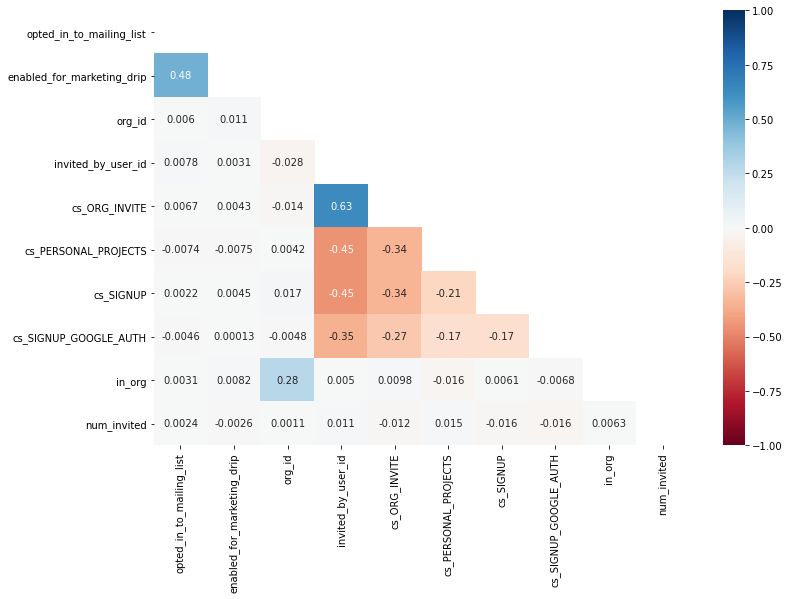

In [200]:
plt.subplots(figsize=(12,8))
mask = np.triu(np.ones_like(features.corr()))
sns.heatmap(features.corr(method='spearman'), mask=mask, vmin=-1, vmax=1, cmap='RdBu', center=0.0, annot=True); 

In [203]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   last_session_creation_time  8823 non-null   datetime64[ns]
 2   opted_in_to_mailing_list    12000 non-null  int64         
 3   enabled_for_marketing_drip  12000 non-null  int64         
 4   org_id                      12000 non-null  int64         
 5   invited_by_user_id          12000 non-null  int32         
 6   cs_ORG_INVITE               12000 non-null  uint8         
 7   cs_PERSONAL_PROJECTS        12000 non-null  uint8         
 8   cs_SIGNUP                   12000 non-null  uint8         
 9   cs_SIGNUP_GOOGLE_AUTH       12000 non-null  uint8         
 10  in_org                      12000 non-null  int32         
 11  num_invited                 12000 non-null  int32     

invited_by_user_id still has one correlation over 0.6, that is with cs_ORG_INVITE.  We'll be ready to remove invited_by_.. if we have issues.

## 4.4 Train/Test Split

In [206]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.25, random_state=21)
print (X_train.shape, X_test.shape)
X_train.head()

(9000, 12) (3000, 12)


,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,cs_ORG_INVITE,cs_PERSONAL_PROJECTS,cs_SIGNUP,cs_SIGNUP_GOOGLE_AUTH,in_org,num_invited
user_id,,,,,,,,,,,,
1730,2013-12-22 17:03:19,2014-06-04 17:03:19,0,0,177,3263,0,0,0,0,1,0
9828,2013-09-20 08:24:49,2013-09-22 08:24:49,0,0,3,5193,0,0,0,0,1,0
8601,2013-08-23 02:26:46,2013-12-14 02:26:46,0,0,156,0,0,0,0,1,1,0
11086,2012-12-09 11:15:44,2013-02-08 11:15:44,1,1,9,8925,1,0,0,0,1,1
9532,2012-07-29 11:09:04,2014-05-31 11:09:04,1,1,219,0,0,1,0,0,1,2


In [210]:
X_test.describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,cs_ORG_INVITE,cs_PERSONAL_PROJECTS,cs_SIGNUP,cs_SIGNUP_GOOGLE_AUTH,in_org,num_invited
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.247000,0.156667,140.707333,3209.180667,0.362333,0.173667,0.168333,0.118667,0.973667,0.519333
std,0.431339,0.363547,124.760317,3878.475046,0.480755,0.378886,0.374224,0.323450,0.160151,1.321442
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,104.000000,935.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,238.000000,6372.500000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,416.000000,11999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000


In [212]:
print(y_train.describe(), y_test.describe())

count    9000.000000
mean        0.138778
std         0.345734
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: adopted, dtype: float64 count    3000.000000
mean        0.135667
std         0.342491
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: adopted, dtype: float64


## 4.4.1 Scaled Data set

We're only scaling org_id.

In [215]:
SS = StandardScaler()
Xs_train = X_train.drop(columns='org_id')
Xs_train.insert(4, "org_id_SS", SS.fit_transform(X_train[['org_id']]))

Xs_test = X_test.drop(columns='org_id')
Xs_test.insert(4, "org_id_SS", SS.transform(X_test[['org_id']]))

In [216]:
Xs_train.describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id_SS,invited_by_user_id,cs_ORG_INVITE,cs_PERSONAL_PROJECTS,cs_SIGNUP,cs_SIGNUP_GOOGLE_AUTH,in_org,num_invited
count,9000.000000,9000.000000,9.000000e+03,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,0.250333,0.146889,8.200847e-17,3181.861556,0.351889,0.176667,0.175778,0.114333,0.973333,0.539889
std,0.433229,0.354015,1.000056e+00,3866.065151,0.477586,0.381408,0.380652,0.318233,0.161116,1.360046
min,0.000000,0.000000,-1.149073e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-9.067841e-01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,-2.687554e-01,860.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,7.811651e-01,6316.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,2.210672e+00,11999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000


In [217]:
Xs_test.describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id_SS,invited_by_user_id,cs_ORG_INVITE,cs_PERSONAL_PROJECTS,cs_SIGNUP,cs_SIGNUP_GOOGLE_AUTH,in_org,num_invited
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.247000,0.156667,-0.012677,3209.180667,0.362333,0.173667,0.168333,0.118667,0.973667,0.519333
std,0.431339,0.363547,1.007603,3878.475046,0.480755,0.378886,0.374224,0.323450,0.160151,1.321442
min,0.000000,0.000000,-1.149073,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-0.922937,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,-0.309137,935.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,0.773089,6372.500000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,2.210672,11999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000


## 4.4.2 Save off features and train and test sets.

In [219]:
features.to_csv('./features.csv')
y_train.to_csv('./y_train.csv')
y_test.to_csv('./y_test.csv')
X_train.to_csv('./X_train.csv')
Xs_train.to_csv('./Xs_train.csv')
X_test.to_csv('./X_test.csv')
Xs_test.to_csv('./Xs_test.csv')